In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from train_model import SimpleNN
from mfbox import gokunet_alpha 


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# load input data
x_test = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/test_input.txt")
# normalize input data
bounds = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/input_limits.txt")
# x_test = (x_test - bounds[:,0]) / (bounds[:,1] - bounds[:,0])

y_test = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/test_output.txt")
y_test = 10**y_test


In [4]:
# load model
emu = gokunet_alpha(path_LA="models/pre_N_L1A_z0_0c_1opt/best_model.pth",path_HA="models/pre_N_LHA_z0_0c_1opt/best_model.pth", path_L2="models/pre_N_L2_z0_0c_1opt/best_model.pth", path_LH="models/pre_N_xLH_stitch_z0_0c_1opt/best_model.pth", bounds_path="data/pre_N_xL-H_stitch_z0/input_limits.txt")

/home/yang/Desktop/GitReps/GokuNet/mfbox.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


In [5]:
k, y_h_pred = emu.predict(x_test)
k_1, y_l1_pred = emu.predict_LA(x_test)
k_2, y_l2_pred = emu.predict_L2(x_test)

In [6]:
k_1.shape

(32,)

In [7]:
k.shape

(64,)

In [8]:
y_l1_pred.shape

(12, 32)

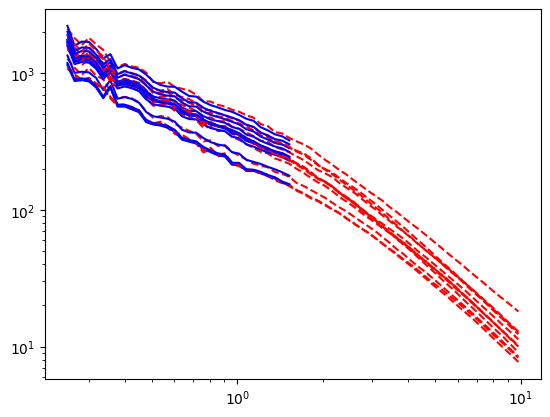

In [9]:
# Plot results
# plt.scatter(x, y, label="True Data")
# load k values

# plot in log-log scale
plt.figure()

# loop over all the test data
for i in range(y_h_pred.shape[0]):
    plt.loglog(k, y_test[i], color="red", linestyle="--", label="True Data") 
    # plt.loglog(k, y_h_pred[i], color="red", label="NN Prediction")
    plt.loglog(k_1, y_l1_pred[i], color="blue", label="NN L1 Prediction")
# plt.legend()
plt.show()

In [10]:
k.max()

np.float64(9.825361078106937)

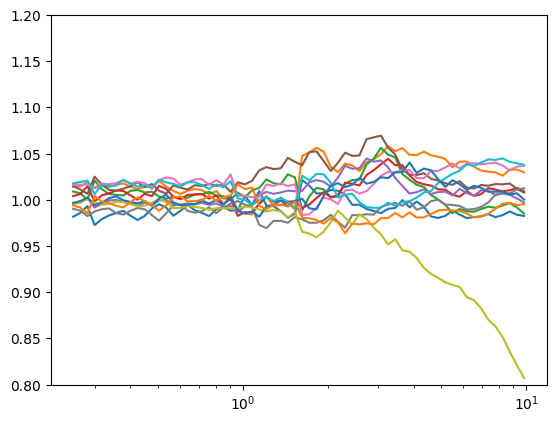

In [11]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    plt.semilogx(k, y_h_pred[i] / y_test[i])
# limit the y-axis 
plt.ylim(0.8, 1.2)
plt.show()

In [12]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred - y_test) / y_test)
print("Relative Mean Absolute Error:", rel_err) 

Relative Mean Absolute Error: 0.017736900119472893


In [13]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred[:,:32] - y_test[:,:32]) / y_test[:,:32])
print("Relative Mean Absolute Error:", rel_err)

Relative Mean Absolute Error: 0.010250794156844044


In [14]:
# calculate relative mean absolute error
rel_err = np.mean(np.abs(y_h_pred[:,32:] - y_test[:,32:]) / y_test[:,32:])
print("Relative Mean Absolute Error:", rel_err)

Relative Mean Absolute Error: 0.025223006082101745


In [15]:
(0.012757600941699561+0.028226519241934728)/2

0.020492060091817144

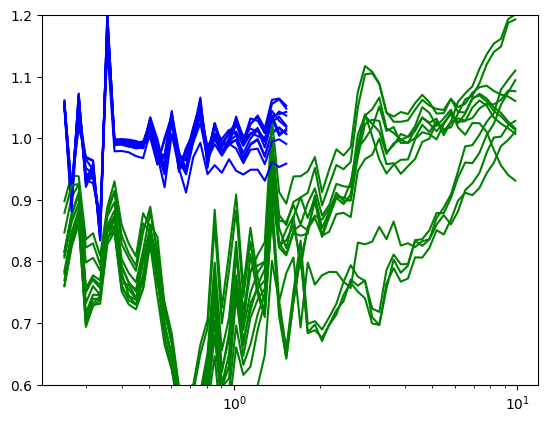

In [16]:
# plot ratio
plt.figure()

for i in range(y_h_pred.shape[0]):
    # plt.semilogx(k, y_h_pred[i] / y_test[i])
    plt.semilogx(k_1, y_l1_pred[i] / y_test[i][:32], color="blue")
    plt.semilogx(k_2, y_l2_pred[i] / y_test[i], color="green")
# limit the y-axis
plt.ylim(0.6, 1.2)
plt.show()

In [17]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_h_pred) - np.log10(y_test))**2)
print("Mean Square Error:", mse)

Mean Square Error: 0.00014243690246757378


In [18]:
# load HF training data
x_th = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/train_input_fidelity_1.txt")
y_th = np.loadtxt("/home/yang/Desktop/GitReps/GokuEmu/data/narrow/matter_power_297_Box25_Part75_27_Box100_Part300_z0/train_output_fidelity_1.txt")
y_th = 10**y_th

In [19]:
# compare the prediction with the training data
_, y_th_pred = emu.predict(x_th)

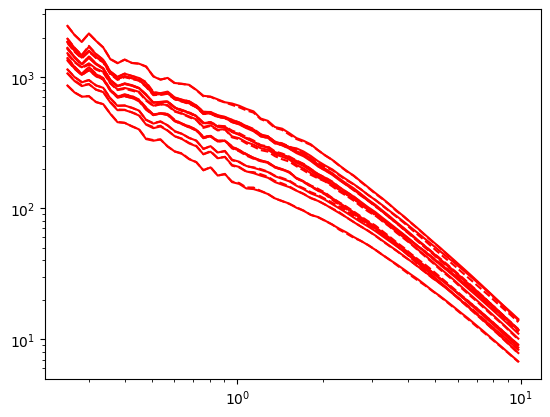

In [20]:


# plot in log-log scale
plt.figure()

# loop over all the test data 
for i in range(y_h_pred.shape[0]):
    plt.loglog(k, y_th[i], color="red", linestyle="--", label="True Data") 
    plt.loglog(k, y_th_pred[i], color="red", label="NN Prediction")
# plt.legend()
plt.show()


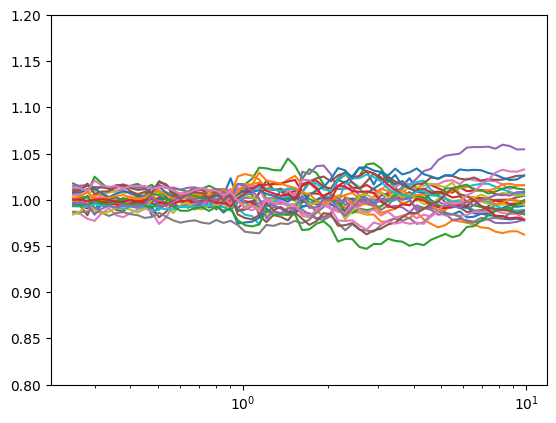

In [21]:
# plot ratio
plt.figure()

for i in range(y_th_pred.shape[0]):
    plt.semilogx(k, y_th_pred[i] / y_th[i])
# limit the y-axis
plt.ylim(0.8, 1.2)
plt.show()

In [22]:
# calculate mean square error (log scale)
mse = np.mean((np.log10(y_th_pred) - np.log10(y_th))**2)
print("Mean Square Error:", mse)

Mean Square Error: 4.1613986369778705e-05
